##  Monte Carlo policy iteration applied to BlackJack

Here I implemento Monte Carlo policy iteration using $\epsilon-\text{greedy}$ with $\epsilon=0.1$ for getting the optimal policy in the game of BlackJack

In [1]:
import gym
import numpy as np
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy.interpolate import griddata

import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
env = gym.make("Blackjack-v0")

In [3]:
class Agent:
    def __init__(self):
        self.policy = {}
        self.state_action_values = {}
        self.visits = {}
        self.gamma = 0.9
        self.epsilon = 0.1
        
    def get_action(self, state):
        action_values = self.state_action_values.get(state)
        if action_values is not None:
            best_action = max(action_values.items(), key=lambda x:x[1])[0]
        else:
            best_action = random.randint(0, 1)
        if random.random() < self.epsilon:
            best_action = random.randint(0, 1)
        return best_action
    
    def update_values(self, episode):
        returns = 0
        for state, action, reward in reversed(episode):
            returns = reward + self.gamma*returns
            # Increase visits dict
            visits_state_dict = self.visits.get(state, {})
            visits_state_dict[action] = visits_state_dict.get(action, 0) + 1
            self.visits[state] = visits_state_dict
            # Update values dict
            state_dict = self.state_action_values.get(state, {})
            error = np.mean(returns) - state_dict.get(action, 0)
            state_dict[action] = state_dict.get(action, 0) + (1/self.visits[state][action]) * error
            self.state_action_values[state] = state_dict
        

In [4]:
agent = Agent()

In [5]:
returns = []
deltas = [1]
for i in range(1000000):
    values = np.array([max([x[1] for x in s.items()]) for s in list(agent.state_action_values.values())])
    done = False
    episode=[]
    
    state = env.reset()
    action = random.randint(0,1)
    new_state, reward, done, _ = env.step(action)
    episode.append((state, action, reward))
    
    while not done:
        state = new_state
        action = agent.get_action(state)
        new_state, reward, done, _ = env.step(int(action))
        episode.append((state, action, reward))
    agent.update_values(episode)
    returns.append(reward)
    new_values = np.array([max([x[1] for x in s.items()]) for s in list(agent.state_action_values.values())])
    if len(values) == len(new_values):
        deltas.append(np.max(np.abs(values-new_values)))
    if np.mean(deltas[-1000:]) < 0.001:
        break

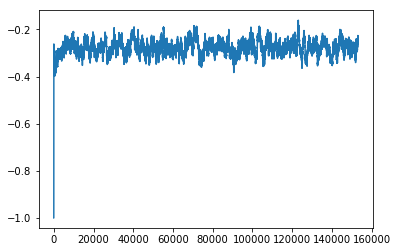

In [6]:
plt.plot(pd.Series(returns).ewm(span=1000).mean())
plt.show()

In [7]:
state_action_values = list(map(lambda x:(x[0], list(x[1].items())), list(agent.state_action_values.items())))

sa_no_ace = list(sorted(list(map(lambda x:(x[0][0], x[0][1], max(x[1][0][1], x[1][1][1])),
                                 filter(lambda x:x[0][2]==False, state_action_values)))))
sa_ace = list(sorted(list(map(lambda x:(x[0][0], x[0][1], max(x[1][0][1], x[1][1][1])),
                              filter(lambda x:x[0][2]==True, state_action_values)))))

In [8]:
y, x, z = zip(*sa_no_ace)

x = np.array(x)
y = np.array(y)
z = np.array(z)

data = [
    go.Surface(
        z=z.reshape((18, 10)),
        x=x.reshape((18,10))[0,:],
        y=y.reshape((18,10))[:,0]
    )
]

layout = go.Layout(
    title="MC BlackJack Agent's value function (No usable Ace)",
    autosize=False,
    width=1000,
    height=700,
    xaxis=dict(title='Dealer card value'),
    yaxis=dict(title="Agent's cards total value")
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot')

![BlackJack optimal policy](../img/MC_BlackJack.png)